In [9]:
import sys

#if branch is stable, will install via pypi, else will install from source
branch = "stable"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@$branch#egg=scvi-tools[tutorials]

In [10]:
def Barplot(which_var, adata, var='clusters', height=3, color = False):
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if 'category' in plotdata.index.dtype.name:
        plotdata.index.reorder_categories(adata.obs[var].cat.categories[::-1])

    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False)
    else:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_ylabel(var)
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
#     ax1.figure.savefig('barplot_'+var+'_proportions_'+which_var+'.pdf', bbox_inches='tight',
#                        dpi=300, orientation='landscape', format= 'pdf', optimize=True)

In [11]:
 palette = ["#E31A1C", "#1F78B4", "#A6CEE3",  "#B2DF8A", "#33A02C", "#FB9A99",  "#FDBF6F", "#FF7F00", "#CAB2D6", "#6A3D9A", "#FFFF99", "#B15928", "#66C2A5",
               "#FC8D62", "#8DA0CB", "#B3B3B3", "#A6D854", "#FFD92F", "#E5C494", "#E78AC3"]

#### Set up scVI environment

In [12]:
import scvi
import scanpy as sc

sc.set_figure_params(figsize=(4, 4))

In [13]:
import pandas as pd 
import numpy as np

# Germ cells

### Read in dataset

In [14]:
path_to_gonads = '/nfs/team292/lg18/with_valentina/gonadsV2_revision/'

In [15]:
adata = sc.read(path_to_gonads + 'FCA-gonads_rawcounts.h5ad')

## Annotate cells

In [16]:
# Add old cluster subname
metaF = pd.read_csv(path_to_gonads+'/FCA-gonads_female_annotated.csv')
metaF = metaF.set_index('Unnamed: 0')
metaF.head()

metaM = pd.read_csv(path_to_gonads+'/FCA-gonads_male_annotated.csv')
metaM = metaM.set_index('Unnamed: 0')
metaM.head()


cell_annotM = metaM['lineage'].to_dict()
cell_annotF = metaF['lineage'].to_dict()
cell_annot = {**cell_annotM , **cell_annotF}
adata.obs['lineage'] = adata.obs_names.map(cell_annot).astype('category')

/opt/conda/envs/scvi-singularity/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (29,30,32) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/envs/scvi-singularity/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [38]:
# Add old cluster subname
metaF = pd.read_csv(path_to_gonads+'/../gonadsV1_submitted/germcells_annotation.csv')
metaF = metaF.set_index('Unnamed: 0')
metaF.head()

# metaM = pd.read_csv(path_to_gonads+'/FCA-gonads_scVI_supporting_late.csv')
# metaM = metaM.set_index('Unnamed: 0')
# metaM.head()


cell_annot = metaF['annotated_clusters'].to_dict()
# cell_annotM = metaM['celltype'].to_dict()
# cell_annot = {**cell_annotM , **cell_annotF}
adata.obs['celltype_v1'] = adata.obs_names.map(cell_annot).astype('category')

In [18]:
adata.obs['lineage'].values.describe()

,counts,freqs
categories,,
CoelEpi,24458,0.061675
Doublet,5821,0.014679
Endothelial,14484,0.036524
Epithelial,20222,0.050993
Erythroid,1371,0.003457
FetalLeydig,2426,0.006118
GermCells,14516,0.036604
Immune,5533,0.013952
Mesenchymal_GATA2,84229,0.212396


In [19]:
adata.obs['celltype_v1'].values.describe()

,counts,freqs
categories,,
GC_mitotic,793,0.002000
PGC,2004,0.005053
PGC_mitotic,869,0.002191
oocyte,854,0.002153
oogonia_STRA8,1663,0.004194
oogonia_meiosis,1714,0.004322
pre-spermatogonia,753,0.001899
NaN,387915,0.978188


In [20]:
adata = adata[[i in ['GermCells'] for i in adata.obs.lineage]]
adata.X.shape

(14516, 28820)

In [21]:
adata.obs['celltype_v1'].values.describe()

,counts,freqs
categories,,
GC_mitotic,793,0.054629
PGC,2004,0.138055
PGC_mitotic,869,0.059865
oocyte,854,0.058832
oogonia_STRA8,1663,0.114563
oogonia_meiosis,1714,0.118077
pre-spermatogonia,752,0.051805
NaN,5867,0.404175


In [22]:
sc.pp.filter_genes(adata, min_counts=3)

Trying to set attribute `.var` of view, copying.
/opt/conda/envs/scvi-singularity/lib/python3.7/site-packages/anndata/_core/views.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  container[idx] = value


### OPTIONAL - Remove cc genes

In [23]:
# ccgs defined in M1
adata = adata[:,[i not in adata.uns['ccgs'] for i in adata.var_names]]
print('Total number of genes after ccg filter: {:d}'.format(adata.n_vars))

Total number of genes after ccg filter: 25182


### OPTIONAL - Remove soup genes

In [24]:
# bdata = adata.copy()
# # Normalize total counts per cell
# sc.pp.normalize_per_cell(bdata, counts_per_cell_after=1e4)
# # Logarithmize the data matrix
# sc.pp.log1p(bdata)
# # Extract highly variable genes
# sc.pp.highly_variable_genes(bdata, n_top_genes=4000)
# highly_variable_genes = bdata.var["highly_variable"]
# bdata = bdata[:, highly_variable_genes]
# # Traspose matrix for a GENE-centered analysis
# bdata = bdata.copy().T
# # Scale data to unit variance and zero mean
# sc.pp.scale(bdata, max_value=10)
# # Scatter plot in PCA coordinates
# sc.tl.pca(bdata)
# # Compute a neighborhood graph of observations
# num_pcs = 30
# sc.pp.neighbors(bdata, n_pcs=num_pcs)
# # Embed the neighborhood graph using UMAP
# sc.tl.umap(bdata)
# # Cluster GENES into subgroups using louvain: resolution < 1 to find less clusters
# sc.tl.louvain(bdata, resolution=1)
# # Locate ccs cluster
# bdata.obs['soup_genes'] = [i in ['HBA1', 'HBB1'] for i in bdata.obs_names]
# bdata.obs['soup_genes'] = [ str(i) for i in  bdata.obs['soup_genes']]
# sc.pl.umap(bdata, color=['soup_genes', 'louvain'], color_map='OrRd')
# print(bdata.obs.loc[[i in ['HBA1', 'HBB1'] for i in bdata.obs_names],'louvain'])

In [25]:
# soup_cl = bdata.obs.loc['HBA1',['louvain']][0]
# print("Soup genes cluster is "+soup_cl)
# # Add unstructured dict-like annotation for soup_genes
# adata.uns['soup_genes'] = list(bdata.obs[bdata.obs['louvain']==soup_cl].index)

# # remove these genes
# adata = adata[:,[i not in adata.uns['soup_genes'] for i in adata.var_names]]
# print('Total number of genes after soup filter: {:d}'.format(adata.n_vars))

### Identify HVGs

!!! Unlike before (at least I think), now they recommend subsetting to highly variable genes before running scVI 

--> the tutorial says anywhere in between 1000 and 10,000 should be fine, so I arbitrarily chose 2000

In [26]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    subset=False,
    batch_key='sex',
    flavor="seurat_v3"
)

Trying to set attribute `.uns` of view, copying.
/opt/conda/envs/scvi-singularity/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:167: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  'highly_variable_nbatches'


In [27]:
# subset object for scVI
bdata = adata[:, adata.var['highly_variable']]
bdata.layers["counts"] = bdata.X.copy() # preserve counts

## Normalize - optional

In [28]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

## scVI

!!! Here you can specify your covariates you want to correct for

In [29]:
scvi.data.setup_anndata(
    bdata,
    layer="counts",
    batch_key='donor',
    categorical_covariate_keys=["sample_source"]
#     continuous_covariate_keys=["percent_mito"]#
)

INFO     Using batches from adata.obs["donor"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              


/opt/conda/envs/scvi-singularity/lib/python3.7/site-packages/scvi/data/_anndata.py:731: UserWarning: Category 3 in adata.obs['_scvi_batch'] has fewer than 3 cells. SCVI may not train properly.
  category, alternate_column_key


INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 14516 cells, 2000 vars, 47        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [30]:
model = scvi.model.SCVI(bdata, n_latent= 50)

In [31]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 50, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Not Trained

To print summary of associated AnnData, use: scvi.data.view_anndata_setup(model.adata)

In [32]:
model.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [19:38<00:00,  2.95s/it, loss=878, v_num=1]


In [33]:
latent = model.get_latent_representation()

In [34]:
adata.obsm["X_scVI"] = latent

### Save latent space

In [35]:
pd.DataFrame(adata.obsm["X_scVI"]).to_csv(path_to_gonads+'/FCA-gonads_XscVI_latent_germcells.csv')
pd.DataFrame(adata.obs).to_csv(path_to_gonads+'/FCA-gonads_XscVI_latentMeta_germcells.csv')

# X_scVI = pd.read_csv(path_to_gonads+'/FCA-gonads_XscVI_latent_germcells.csv', index_col=0)
# adata.obsm["X_scVI"] = X_scVI.to_numpy()

### Visualization and Clustering

In [36]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.4)

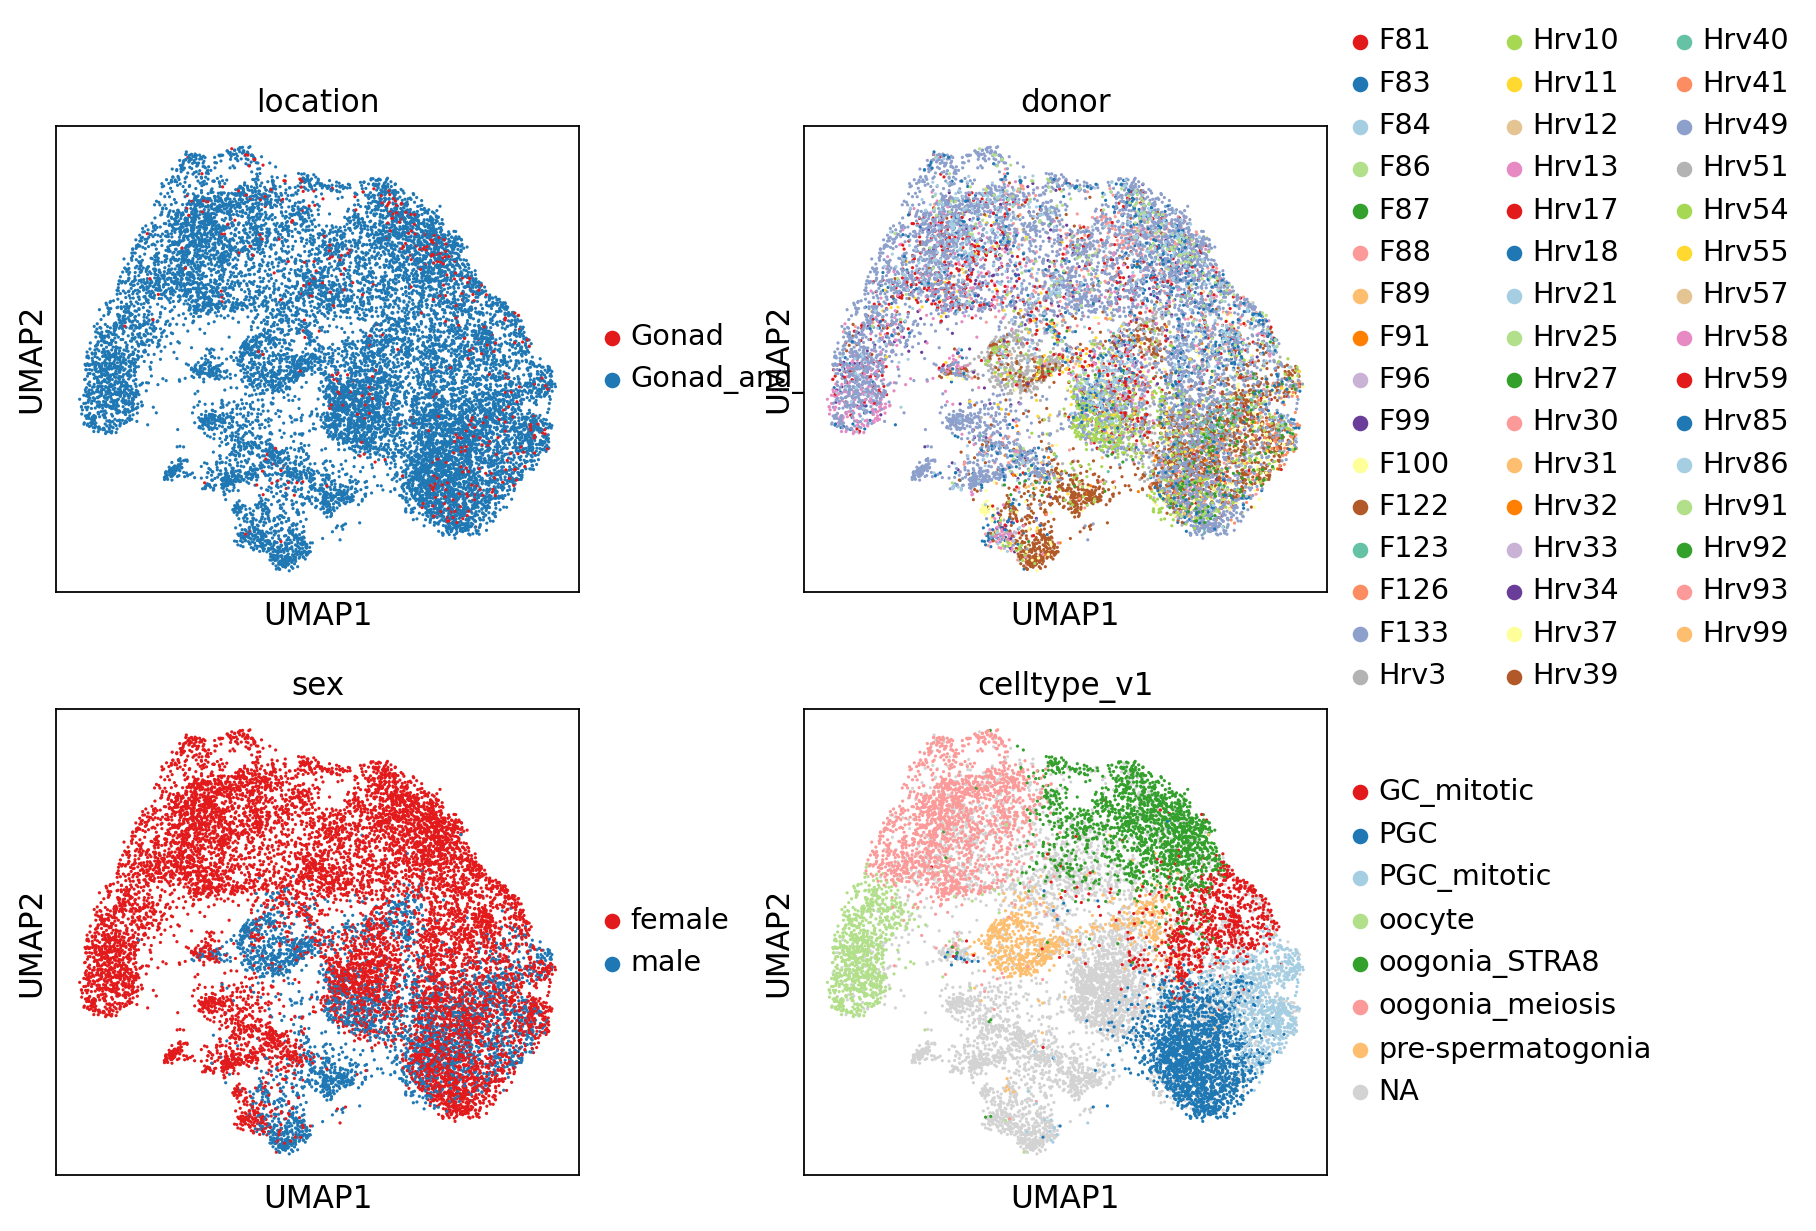

In [39]:
sc.pl.umap(
    adata,
    color=[ "location", 'donor', 'sex', "celltype_v1"], 
    palette = palette,
    frameon=True, ncols = 2, wspace = 0.3
)

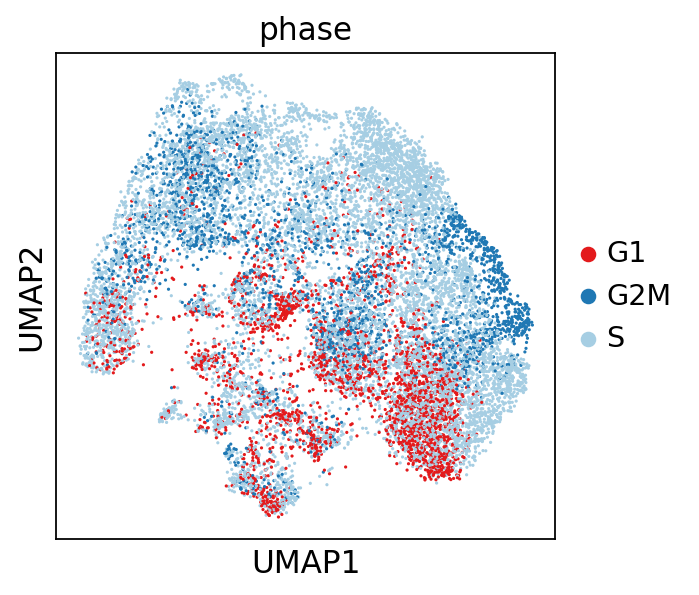

In [42]:
sc.pl.umap(
    adata,
    color=["phase"], 
    palette = palette,
    frameon=True, ncols = 2, wspace = 0.3
)

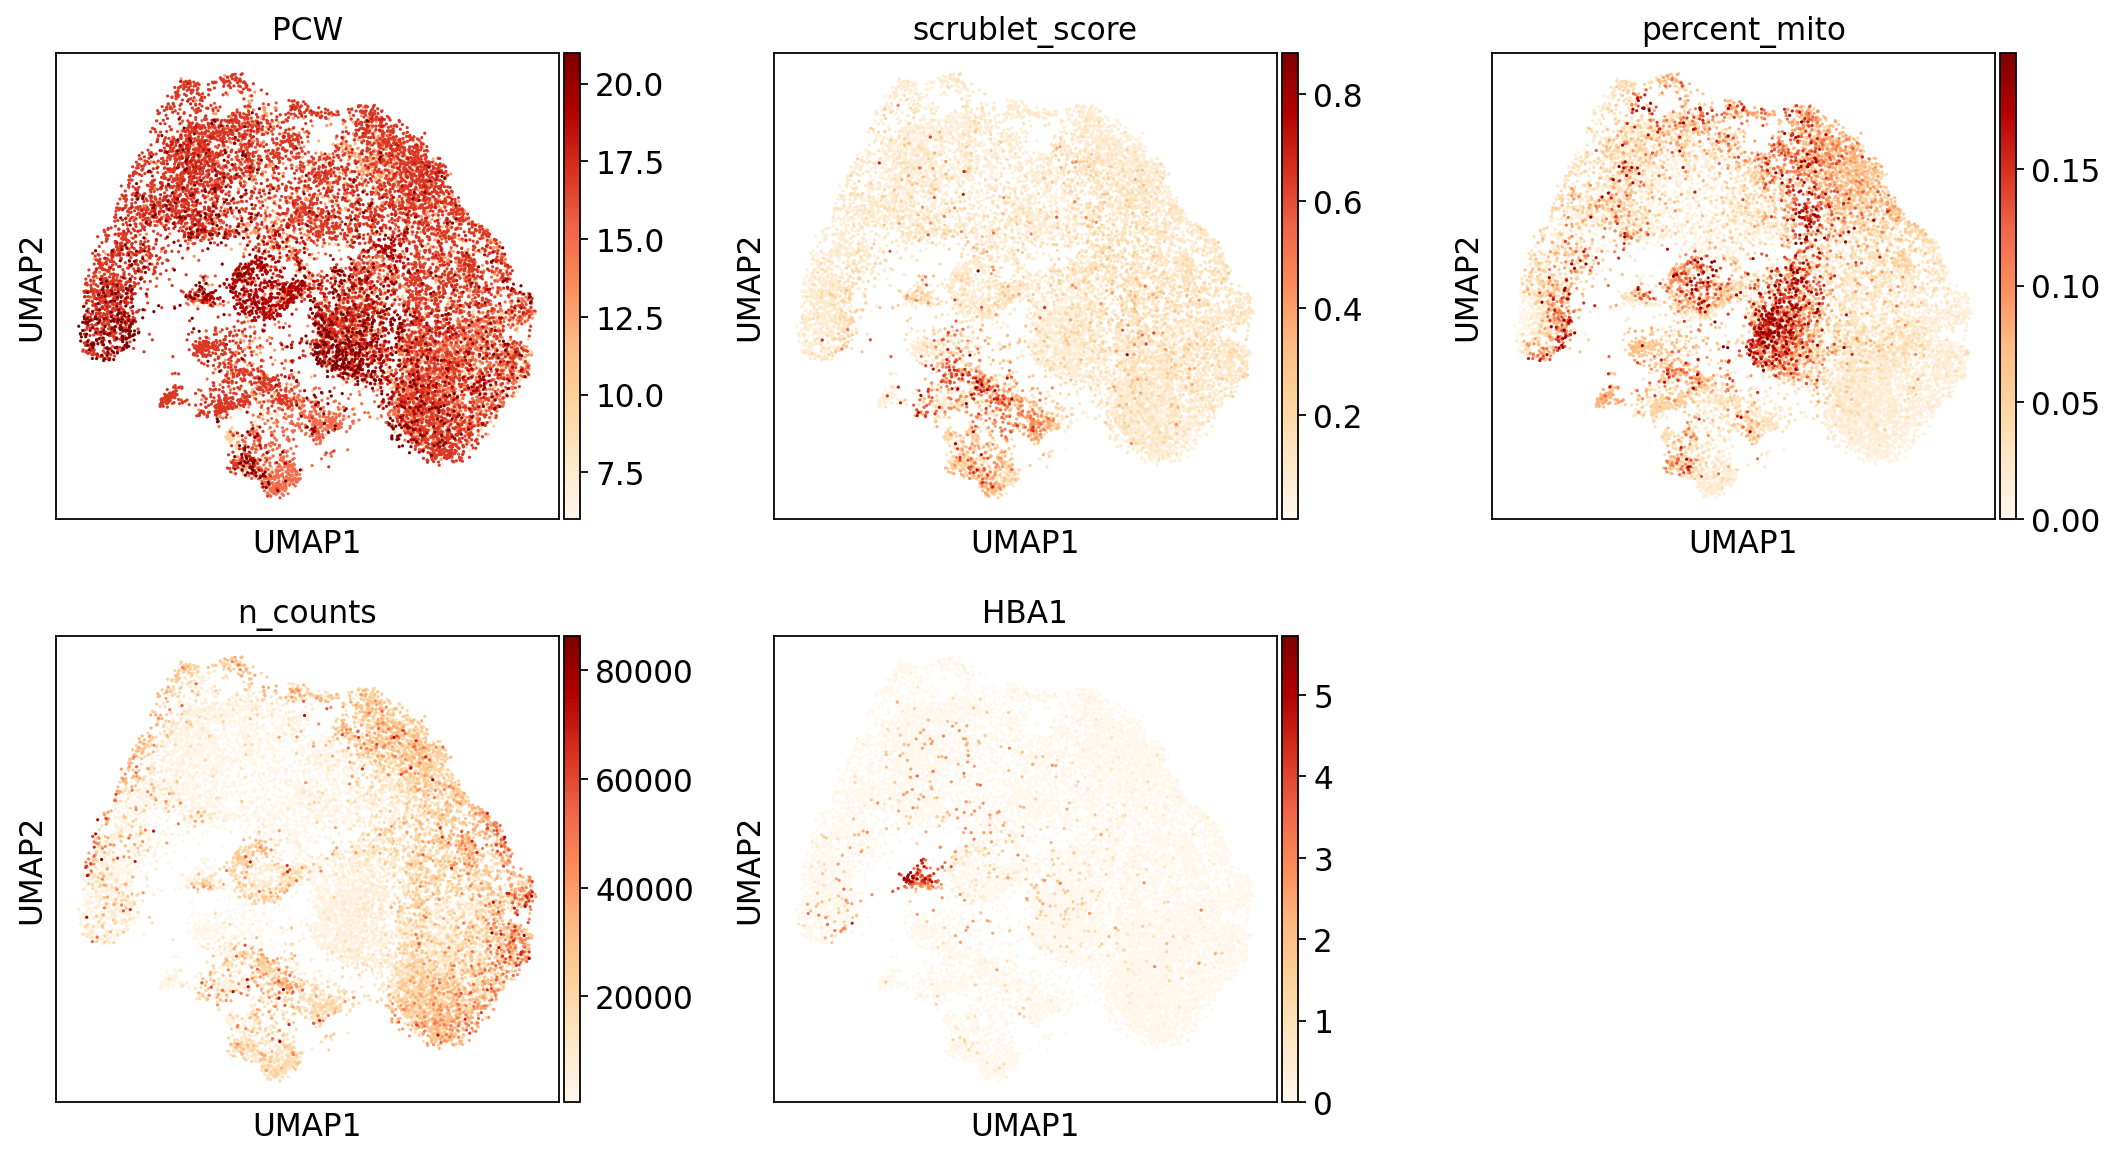

In [43]:
sc.pl.umap(
    adata,
    color=['PCW', 'scrublet_score',  'percent_mito', 'n_counts', 'HBA1'], color_map = "OrRd",
    frameon=True, ncols = 3, wspace = 0.3
)